# Compare communities to reference with Jaccard similarity

In [8]:
import scipy as sp

In [1]:
ref_nodes = 'data/FACS_cellontology.membership'
test_nodes = 'data/test_FACS.nodes'

dfs = [pd.read_csv(x, header=None, sep='\t') for x in [ref_nodes, test_nodes]]

partitions = []
for df in dfs:
    clusters = []
    for i, row in df.iterrows():
        clusters.append(row[2].split(' '))
    partitions.append(clusters)
    
nnode = 44950

In [2]:
def partition_to_membership_matrix(partition, nnode):
    clusters = sorted([p for p in partition], key=len, reverse=True)
    row, col = [], []
    for i in range(len(clusters)):
        row.extend([i for _ in clusters[i]])
        col.extend([int(x)-1 for x in clusters[i]])
#         print(np.array(list(map(int,clusters[i]))))
    row = np.array(row)
    col = np.array(col)
    data = np.ones_like(row, dtype=int)
    C = sp.sparse.coo_matrix((data, (row, col)), shape=(len(clusters), nnode))
    C = C.tocsr()
    return C

In [45]:
matA = partition_to_membership_matrix(partitions[0], nnode) #ref
matB = partition_to_membership_matrix(partitions[1], nnode) #hidef

both = matA.dot(matB.T)

either = (np.tile(matA.getnnz(axis=1), (matB.shape[0],1)) + matB.getnnz(axis=1)[:, np.newaxis]).T -both
jac = 1.0*both/either
jacmax = np.max(jac, axis=1) # best match for each reference
jacmax_2 = np.max(jac, axis=0).T # best match for each detected community
jacargmax =  np.array(np.argmax(jac, axis=1)).ravel()
jacargmax_2 = np.array(np.argmax(jac, axis=0)).ravel()

In [22]:
dfs[0].sort_values(by=1, ascending=False, inplace=True)
dfs[1].sort_values(by=1, ascending=False, inplace=True)
dfs[0].reset_index(inplace=True, drop=True)
dfs[1].reset_index(inplace=True, drop=True)

In [50]:
records = []
for i, row in dfs[0].iterrows():
    records.append([row[0], row[1], dfs[1].loc[jacargmax[i],0], float(jacmax[i])])
df_jac = pd.DataFrame.from_records(records, columns=['Reference', 'No. cells', 'Best matched community', 'Jaccard similarity'])
df_jac.to_csv('data/summary_jaccard_ref2comm.tsv',sep='\t', header=False, index=False)

records = []
for i, row in dfs[1].iterrows():
    records.append([row[0], row[1], dfs[0].loc[jacargmax_2[i],0], float(jacmax_2[i])])
df_jac_2 = pd.DataFrame.from_records(records, columns=['Community', 'No. cells', 'Best matched reference', 'Jaccard similarity'])
df_jac_2.to_csv('data/summary_jaccard_comm2ref.tsv',sep='\t', header=False, index=False)

save the results

# Visualize HiDef clusters in tSNE/UMAP

Here we provide an example to integrate the HiDeF results with ScanPy, a popular single-cell analysis tool

In [12]:
import scanpy as sc
import numpy as np

import anndata2ri

In [13]:
anndata2ri.activate()

#Loading the rpy2 extension enables cell magic to be used
#This runs R code in jupyter notebook cells
%load_ext rpy2.ipython

sc.settings.verbosity = 3
sc.logging.print_versions()

scanpy==1.4.4.post1 anndata==0.6.22.post1 umap==0.3.10 numpy==1.16.4 scipy==1.3.1 pandas==0.25.1 scikit-learn==0.21.2 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


In [15]:
%%R

load('data/FACS_all.Robj')

Note this file is big, thus we do not provide it in this repo.   
Please see the original Tabula Muris data repository: https://doi.org/10.6084/m9.figshare.5821263.v2

In [17]:
%%R -o tiss_sce

suppressPackageStartupMessages(library(Seurat))
#convert the Seurat object to a SingleCellExperiment object
tiss_sce <- as.SingleCellExperiment(tiss_FACS)

tiss_sce

class: SingleCellExperiment 
dim: 23341 44949 
metadata(0):
assays(2): X logcounts
rownames(23341): 0610005C13Rik 0610007C21Rik ... l7Rn6
  zsGreen_transgene
rowData names(4): gene gene.mean gene.dispersion gene.dispersion.scaled
colnames(44949): A1.B000126.3_39_F.1.1 A1.B000127.3_38_F.1.1 ...
  P9.MAA001892.3_38_F.1.1 P9.MAA001894.3_39_F.1.1
colData names(20): nGene nReads ... color ident
reducedDimNames(2): PCA TSNE
spikeNames(0):


In [ ]:
tiss_sce.write('data/FACS_all_anndata.h5ad')
FACS_all = sc.read('data/FACS_all_anndata.h5ad')

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

tSNE projection in the original paper

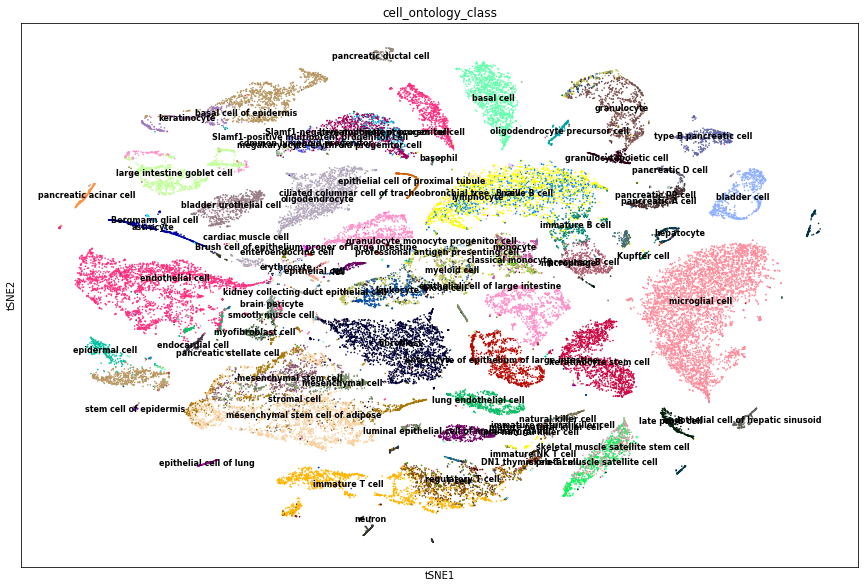

In [33]:
fig, ax= plt.subplots(1,1, figsize=(15, 10))
sc.pl.tsne(FACS_all, color = ['cell_ontology_class'], ax=ax, size=10, 
           legend_loc='on data', legend_fontsize=8)

project any HiDeF cluster to existing projection

In [34]:
df_metadata = pd.read_csv('data/FACS_metadata.tsv', sep='\t')
df_metadata['cell.index'] = np.arange(df_metadata.shape[0])+1

In [39]:
df_hier = pd.read_csv('data/test_FACS.nodes', 
                      sep='\t', header=None)

for i, row in df_hier.iterrows():
    if i == 0:
        continue
    clust_name = row[0]
    cell_inds = list(map(int, row[2].split()))
    df_metadata[clust_name] = 'False'
    df_metadata.loc[df_metadata['cell.index'].isin(cell_inds), clust_name] = 'True'
    FACS_all.obs[clust_name] = df_metadata[clust_name]

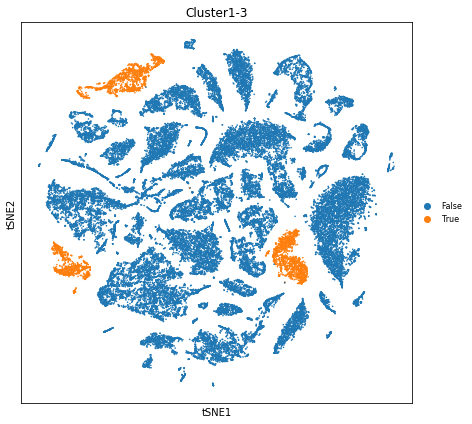

In [44]:
# for example, examine HiDeF cluster1-3, which highly matched to "epidermal cell" (Jaccard similarity 0.975)

fig, ax= plt.subplots(1,1, figsize=(7, 7))
sc.pl.tsne(FACS_all, color = ['Cluster1-3'], ax=ax, size=10, 
           legend_fontsize=8)